In [4]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

In [54]:
import matplotlib.pyplot as plt 
import numpy as np 

### PatchEmbedding

The first part of ViT is to split the image in different patches. 

In [59]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, input_channels, embedding_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim

        self.projection = nn.Conv2d(
            in_channels=input_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        B, C, H, W = x.shape
        print(f'X shape: {x.shape}')
        assert H%self.patch_size==0 and W%self.patch_size==0, "Image size must be divisible by patch size"

        x = self.projection(x)
        print(f'After projection, X shape: {x.shape}')
        print(f'After flatten(2), X shape: {x.flatten(2).shape}')
        x = x.flatten(2).transpose(1, 2)

        return x

In [46]:
patch_embedding = PatchEmbedding(patch_size=4, input_channels=3, embedding_dim=64)
patch_embedding

PatchEmbedding(
  (projection): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
)

In [47]:
patch_embedding(torch.randn(32,3,32,32)).shape

X shape: torch.Size([32, 3, 32, 32])
After projection, X shape: torch.Size([32, 64, 8, 8])
After flatten(2), X shape: torch.Size([32, 64, 64])


torch.Size([32, 64, 64])

In [51]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

data_train = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(data_train, batch_size=1, shuffle=True)

Label: 6


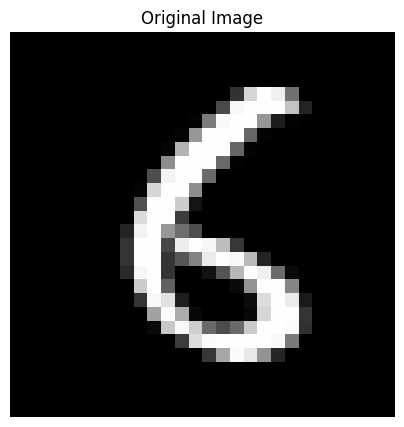

X shape: torch.Size([1, 1, 28, 28])
After projection, X shape: torch.Size([1, 8, 4, 4])
After flatten(2), X shape: torch.Size([1, 8, 16])


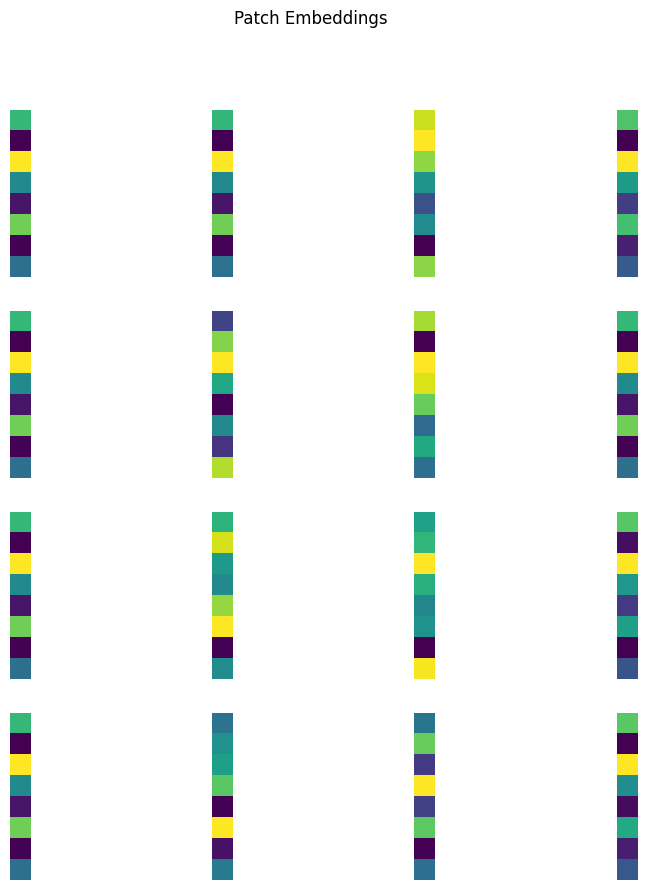

In [60]:
def visualize_patch_embedding():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    patch_size = 7
    embedding_dim = 8
    patch_embedder = PatchEmbedding(
        patch_size=patch_size,
        input_channels=1,
        embedding_dim=embedding_dim
    ).to(device)

    for batch in data_loader:
        img, label = batch
        img = img.to(device)
        print(f"Label: {label.item()}")

        # original
        plt.figure(figsize=(5, 5))
        plt.title("Original Image")
        plt.imshow(img.squeeze(0).squeeze(0).cpu().numpy(), cmap="gray")
        plt.axis("off")
        plt.show()

        embedded_patches = patch_embedder(img)

        # as grid
        patches = embedded_patches.squeeze(0).detach().cpu().numpy()
        num_patches = patches.shape[0]
        fig, axes = plt.subplots(
            nrows=int(np.sqrt(num_patches)), 
            ncols=int(np.sqrt(num_patches)), 
            figsize=(10, 10)
        )

        for i, ax in enumerate(axes.flat):
            if i < num_patches:
                ax.imshow(patches[i].reshape(embedding_dim, -1), cmap="viridis")
                ax.axis("off")

        plt.suptitle("Patch Embeddings")
        plt.show()
        break

visualize_patch_embedding()
